**Shashi Sharma, ss139529@gmail.com**

# Amazon Fine Food Reviews Analysis using KNN KD_TREE


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
ActualScore = filtered_data['Score']
positiveNegative = ActualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head() #BY DEFAULT IT DISPLAY 5 ROWS

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(19354, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
Score=final['Score']
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(19354, 10)


1    16339
0     3015
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I have two cats My big boy has eaten these and never had a problem as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months My girl cat throws up every time she eats this particular flavor Since I treat them equally these are no longer purchased I hate to see my girl sick so I just recommend you watch your cats after you give them these treats If not a problem carry on 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(word.lower() for word in sentance.split() if word.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 19354/19354 [00:05<00:00, 3672.63it/s]


In [23]:
#comparing the raw data and the preprocessed data:

print(sent_0) 
print("####")
print(preprocessed_reviews[0])

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!
####
used victor fly bait seasons ca not beat great product


In [24]:
preprocessed_reviews[1500]

'two cats big boy eaten never problem matter fact never vomited hair ball since adopted months girl cat throws every time eats particular flavor since treat equally no longer purchased hate see girl sick recommend watch cats give treats not problem carry'

# [4] Featurization

#### Splitting the preprocessed_reviews data:

In [25]:
Y = Score
X= preprocessed_reviews

In [26]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting

In [27]:
print(np.shape(X_train), np.shape(y_train))
print(np.shape(X_test), np.shape(y_test))


(12967,) (12967,)
(6387,) (6387,)


## [4.1] BAG OF WORDS

In [28]:
#BoW
count_vect = CountVectorizer()
count_vect.fit(X_train) # fit has to happen only on train data
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
X_test_bow = count_vect.transform(X_test)

print("the type of count vectorizer ",type(X_train_bow))
print("the number of unique words in X_train",X_train_bow.shape[1])
print('='*50)
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)
print("="*50)

some feature names  ['aa', 'aaaa', 'aaaaa', 'aaaand', 'aafco', 'aahs', 'ab', 'abandon', 'abandoned', 'abandoning']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in X_train 21449
After vectorizations
(12967, 21449) (12967,)
(6387, 21449) (6387,)


## [4.2] Bi-Grams and n-Grams.

In [31]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000) 
count_vect.fit(X_train)
print('='*50)

X_train_big = count_vect.transform(X_train)
X_test_big = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_big))
print('='*50)

print("After vectorizations")
print(X_train_big.shape, y_train.shape)
print(X_test_big.shape, y_test.shape)

print("the number of unique words including both unigrams and bigrams in X_train ", X_train_big.shape[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
After vectorizations
(12967, 5000) (12967,)
(6387, 5000) (6387,)
the number of unique words including both unigrams and bigrams in X_train  5000


## [4.3] TF-IDF

In [32]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)
print("the type of tf_idf_vect",type(X_train_big))
print('='*50)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)
print('='*50)
print("The number of unique words in tf_idf_vect of X_train ", X_train_tfidf.shape[1])

the type of tf_idf_vect <class 'scipy.sparse.csr.csr_matrix'>
After vectorizations
(12967, 7905) (12967,)
(6387, 7905) (6387,)
The number of unique words in tf_idf_vect of X_train  7905


## [4.4] Word2Vec

In [33]:
# Train your own Word2Vec model using your own text corpus
i=0
X_train_los=[]
for sentance in X_train:
    X_train_los.append(sentance.split())

k=0
X_test_los=[]
for sentance in X_test:
    X_test_los.append(sentance.split())

In [34]:
# min_count = 5 considers only words that occured atleast 5 times
#Conveting X_train to w2v
X_trainw2v=Word2Vec(X_train_los,min_count=5,size=50, workers=4)
print(X_trainw2v.wv.most_similar('great'))
print('='*50)


X_testw2v=Word2Vec(X_test_los,min_count=5,size=50, workers=4)
print(X_testw2v.wv.most_similar('great'))



[('good', 0.8291555643081665), ('excellent', 0.7973042726516724), ('amazing', 0.764111340045929), ('wonderful', 0.7423223257064819), ('awesome', 0.735611081123352), ('fantastic', 0.7165090441703796), ('quick', 0.7147123217582703), ('well', 0.696273684501648), ('decent', 0.6953158378601074), ('love', 0.6585338711738586)]
[('good', 0.9505149126052856), ('wonderful', 0.9480468034744263), ('alternative', 0.9480077028274536), ('excellent', 0.945997953414917), ('calling', 0.9387681484222412), ('regular', 0.9386386871337891), ('kavli', 0.9346585273742676), ('dijon', 0.9328336119651794), ('nutty', 0.9325789213180542), ('chips', 0.9318314790725708)]


In [35]:
X_train_w2v_words = list(X_trainw2v.wv.vocab)
print("number of words that occured minimum 5 times in X_train_w2v_words",len(X_train_w2v_words))
print('='*50)

X_test_w2v_words = list(X_testw2v.wv.vocab)
print("number of words that occured minimum 5 times in X_train_w2v_words",len(X_test_w2v_words))
print('='*50)

number of words that occured minimum 5 times in X_train_w2v_words 6864
number of words that occured minimum 5 times in X_train_w2v_words 4709


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [36]:
# average Word2Vec for X_TRAIN
X_train_w2v= []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_train_los: # for each review/sentence in X_TRAIN
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in X_train_w2v_words:
            vec = X_trainw2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_w2v.append(sent_vec)
print(len(X_train_w2v))
print(len(X_train_w2v[0]))
print('='*50)


# average Word2Vec for X_TEST
X_test_w2v=[];
for sent in X_test_los: 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent:
        if word in X_test_w2v_words:
            vec = X_testw2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_w2v.append(sent_vec)
print(len(X_test_w2v))
print(len(X_test_w2v[0]))

12967
50
6387
50


#### [4.4.1.2] TFIDF weighted W2v

In [37]:
# Sentence = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
X_train_tfidf_los = model.fit(X_train)
X_train_tfidf_feat = model.get_feature_names()
# we are converting a dictionary with word as a key, and the idf as a value
X_train_dictionary = dict(zip(X_train_tfidf_feat, list(X_train_tfidf_los.idf_)))


model2 = TfidfVectorizer()
X_test_tfidf_los = model2.fit(X_test)
X_test_tfidf_feat = model2.get_feature_names()
# we are converting a dictionary with word as a key, and the idf as a value
X_test_dictionary = dict(zip(X_test_tfidf_feat, list(X_test_tfidf_los.idf_)))

In [38]:
# TF-IDF weighted Word2Vec for X_TRAIN, X_CV and X_test:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
X_train_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
a=0;
for sent in X_train_los: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in X_train_w2v_words and word in X_train_tfidf_feat:
            vec = X_trainw2v.wv[word]
            tf_idf = X_train_dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidfw2v.append(sent_vec)
    a += 1


X_test_tfidfw2v = [];
b=0;
for sent in X_test_los: 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in X_test_w2v_words and word in X_test_tfidf_feat:
            vec = X_testw2v.wv[word]
            tf_idf = X_test_dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidfw2v.append(sent_vec)
    b += 1

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [0]:
# Please write all the code with proper documentation

In [39]:
#BoW
count_vect1 = CountVectorizer(min_df=10, max_features=500)
count_vect1.fit(X_train) # fit has to happen only on train data

X_train_bow1 = count_vect1.transform(X_train)
X_test_bow1 = count_vect1.transform(X_test)

In [40]:
# Converting the vectors into dense matrix.
X_train_bow1=X_train_bow1.toarray()
X_test_bow1=X_test_bow1.toarray()

In [41]:
# Standadizing both X_TRAIN_tfidf AND X_TEST_tfidf
X_train_bow1_S = StandardScaler(with_mean=False).fit_transform(X_train_bow1)
X_test_bow1_S = StandardScaler(with_mean=False).fit_transform(X_test_bow1)

In [44]:
##Brute force KNN
# Using Grid search method to find the optimal K.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
neigh = KNeighborsClassifier(algorithm='kd_tree')
k= list(range(1,51,5))
parameters = {'n_neighbors':k}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc', return_train_score= True )
clf= clf.fit(X_train_bow1_S, y_train)

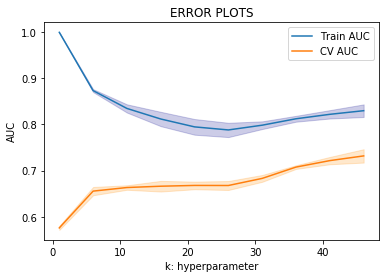

In [45]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(k, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [46]:
l=0
for i in k:
    print (i,train_auc[l],cv_auc[l],train_auc[l]-cv_auc[l] )
    l+=1

1 0.9997493734335839 0.5756404886071872 0.42410888482639675
6 0.8733605033749788 0.6554347686379942 0.21792573473698462
11 0.83468224264679 0.6632007843885748 0.17148145825821526
16 0.8117999864122153 0.6660624655717348 0.14573752084048053
21 0.7947185179357116 0.6677636566036715 0.12695486133204004
26 0.7880840373099106 0.6676043585753985 0.12047967873451215
31 0.7983819088881576 0.683016742391591 0.11536516649656658
36 0.8123173712039247 0.7075504378870323 0.10476693331689235
41 0.8219487660325999 0.7215877628638357 0.10036100316876417
46 0.8298111448937573 0.7317859252239318 0.09802521966982547


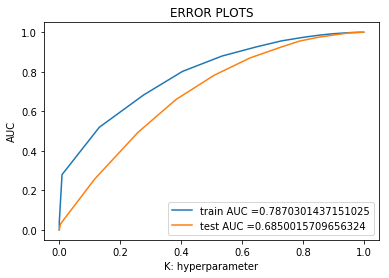

In [80]:
#training our model with the best optimal K, and find the AUC on test data and plot the ROC curve on both train and test. 
neigh = KNeighborsClassifier(n_neighbors=31, algorithm='kd_tree')
neigh.fit(X_train_bow1_S, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow1_S)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow1_S)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Train confusion matrix


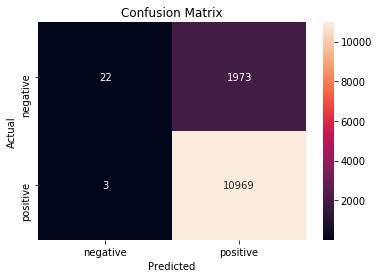

Test confusion matrix


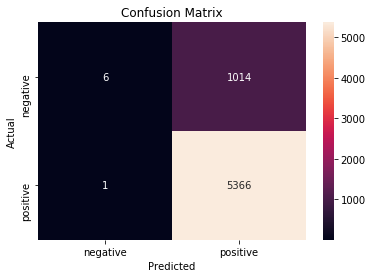

In [81]:
print("Train confusion matrix")
matrix_train= confusion_matrix(y_train, neigh.predict(X_train_bow1_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train = pd.DataFrame(matrix_train,columns,index)
sns.heatmap(df_matrix_train, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test= confusion_matrix(y_test, neigh.predict(X_test_bow1_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test = pd.DataFrame(matrix_test,columns,index)
sns.heatmap(df_matrix_test, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Observation:
- Taking best k=31 as per the graph and the for loop result. Condisering the highest CV_SCORE and Train_score and the gap between them.
- The AUC of the train data and test data is > 0.5
- From the confusion matrix TPR is very high and TNR is very low. The model is bias towards +ve class.

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [0]:
# Please write all the code with proper documentation

In [56]:
#BoW
tf_idf_vect1 = TfidfVectorizer(min_df=10, max_features=500)
tf_idf_vect1.fit(X_train) # fit has to happen only on train data

X_train_tfidf1 = tf_idf_vect1.transform(X_train)
X_test_tfidf1 = tf_idf_vect1.transform(X_test)

In [57]:
# Converting the vectors into dense matrix.
X_train_tfidf1=X_train_tfidf1.toarray()
X_test_tfidf1=X_test_tfidf1.toarray()

In [58]:
# Standadizing both X_TRAIN_tfidf AND X_TEST_tfidf
X_train_tfidf_S = StandardScaler(with_mean=False).fit_transform(X_train_tfidf1)
X_test_tfidf_S = StandardScaler(with_mean=False).fit_transform(X_test_tfidf1)

In [59]:
## KD-Tree KNN
#Using Grid search method to find the optimal K.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
neigh1 = KNeighborsClassifier(algorithm='kd_tree')
k= list(range(1,50,5))
parameters = {'n_neighbors':k}
clf1 = GridSearchCV(neigh1, parameters, cv=3, scoring='roc_auc', return_train_score= True )
clf1= clf1.fit(X_train_tfidf_S, y_train)

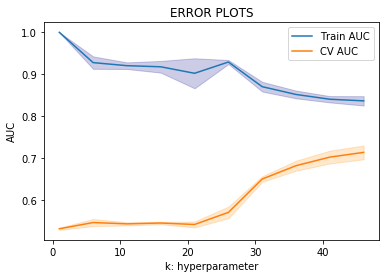

In [60]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc1= clf1.cv_results_['mean_train_score']
train_auc_std1= clf1.cv_results_['std_train_score']
cv_auc1 = clf1.cv_results_['mean_test_score'] 
cv_auc_std1= clf1.cv_results_['std_test_score']

plt.plot(k, train_auc1, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k,train_auc1 - train_auc_std1,train_auc1 + train_auc_std1,alpha=0.2,color='darkblue')

plt.plot(k, cv_auc1, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k,cv_auc1 - cv_auc_std1,cv_auc1 + cv_auc_std1,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [61]:
l=0
for i in k:
    print (i,train_auc1[l],cv_auc1[l],train_auc1[l]-cv_auc1[l] )
    l+=1

1 0.9997493734335839 0.5318511044673602 0.4678982689662238
6 0.9276042587764004 0.5467426797636842 0.3808615790127162
11 0.9203084288759017 0.5436099248743027 0.376698504001599
16 0.9176742471029454 0.5455786435543845 0.37209560354856097
21 0.9021539183365131 0.5420887819478033 0.36006513638870985
26 0.9289994093383055 0.5708981722651996 0.3581012370731059
31 0.8702738443260477 0.650322211285503 0.21995163304054466
36 0.8517318204177254 0.6821645161156827 0.1695673043020427
41 0.8403716773217357 0.70254535745585 0.13782631986588567
46 0.836523426564629 0.7138421713762486 0.12268125518838036


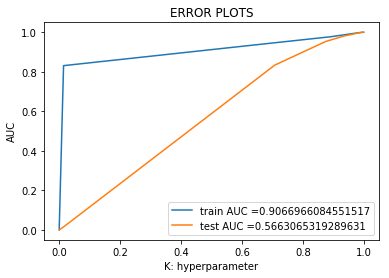

In [82]:
#training our model with the best optimal K, and find the AUC on test data and plot the ROC curve on both train and test. 
neigh1 = KNeighborsClassifier(n_neighbors=32, algorithm='kd_tree')
neigh1.fit(X_train_tfidf_S, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr1, train_tpr1, thresholds1 = roc_curve(y_train, neigh1.predict_proba(X_train_tfidf_S)[:,1])
test_fpr1, test_tpr1, thresholds1 = roc_curve(y_test, neigh1.predict_proba(X_test_tfidf_S)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Train confusion matrix


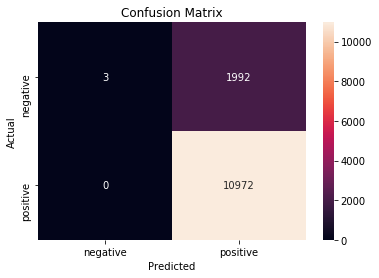

Test confusion matrix


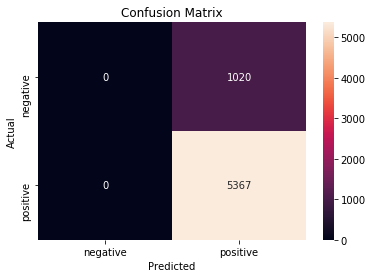

In [64]:
# Confusion Metric
print("Train confusion matrix")
matrix_train1= confusion_matrix(y_train, neigh1.predict(X_train_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train1 = pd.DataFrame(matrix_train1,columns,index)
sns.heatmap(df_matrix_train1, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test1= confusion_matrix(y_test, neigh1.predict(X_test_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test1 = pd.DataFrame(matrix_test1,columns,index)
sns.heatmap(df_matrix_test1, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Observation:
- Taking best k=32 as per the graph and the for loop result. Condisering the highest CV_SCORE and Train_score and the gap between them.
- The AUC of the train data > 0.5 and test data close to 0.5
- The model is completely bias towards +ve class.

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [65]:
# Standadizing both X_TRAIN_tfidf AND X_TEST_tfidf
X_train_w2v_S = StandardScaler(with_mean=False).fit_transform(X_train_w2v)
X_test_w2v_S = StandardScaler(with_mean=False).fit_transform(X_test_w2v)

In [66]:
##KD-TREE KNN
# Using Grid search method to find the optimal K.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
neigh2 = KNeighborsClassifier(algorithm='kd_tree')
k= list(range(1,50,5))
parameters = {'n_neighbors':k}
clf2 = GridSearchCV(neigh2, parameters, cv=3, scoring='roc_auc', return_train_score= True )
clf2= clf2.fit(X_train_w2v_S, y_train)

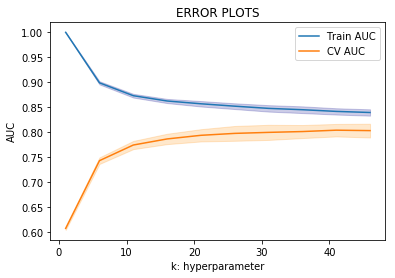

In [67]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc2= clf2.cv_results_['mean_train_score']
train_auc_std2= clf2.cv_results_['std_train_score']
cv_auc2 = clf2.cv_results_['mean_test_score'] 
cv_auc_std2= clf2.cv_results_['std_test_score']

plt.plot(k, train_auc2, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k,train_auc2 - train_auc_std2,train_auc2 + train_auc_std2,alpha=0.2,color='darkblue')

plt.plot(k, cv_auc2, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k,cv_auc2 - cv_auc_std2,cv_auc2 + cv_auc_std2,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [68]:
l=0
for i in k:
    print (i,train_auc2[l],cv_auc2[l],train_auc2[l]-cv_auc2[l] )
    l+=1

1 0.9997493734335839 0.6078802609980762 0.3918691124355077
6 0.8988252244997851 0.7432655079261299 0.1555597165736552
11 0.8731011536735199 0.7745102858916596 0.09859086778186033
16 0.8625165526461197 0.7866623770679092 0.0758541755782105
21 0.8569395905678882 0.7939143838691349 0.06302520669875322
26 0.8521501869329416 0.7977676302863673 0.05438255664657432
31 0.8477523082773937 0.7997874708695265 0.04796483740786717
36 0.8450883042467954 0.801432658783574 0.043655645463221426
41 0.8417158111445664 0.8041744858572436 0.03754132528732279
46 0.8395375473183222 0.8032983205240408 0.036239226794281376


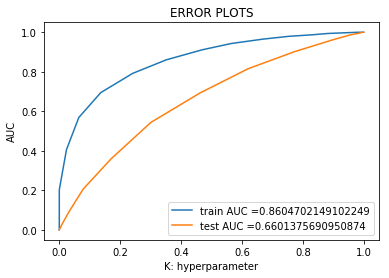

In [83]:
#training our model with the best optimal K, and find the AUC on test data and plot the ROC curve on both train and test. 
neigh2 = KNeighborsClassifier(n_neighbors=21, algorithm='kd_tree')
neigh2.fit(X_train_w2v_S, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr2, train_tpr2, thresholds2 = roc_curve(y_train, neigh2.predict_proba(X_train_w2v_S)[:,1])
test_fpr2, test_tpr2, thresholds2 = roc_curve(y_test, neigh2.predict_proba(X_test_w2v_S)[:,1])

plt.plot(train_fpr2, train_tpr2, label="train AUC ="+str(auc(train_fpr2, train_tpr2)))
plt.plot(test_fpr2, test_tpr2, label="test AUC ="+str(auc(test_fpr2, test_tpr2)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Train confusion matrix


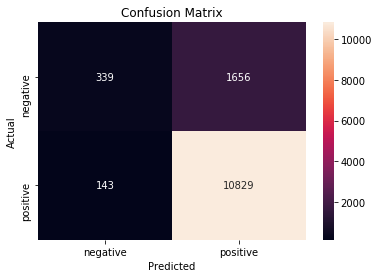

Test confusion matrix


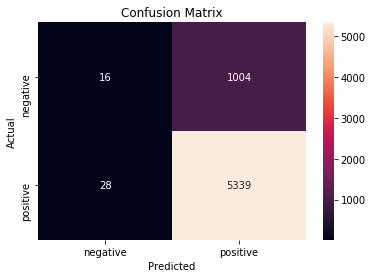

In [84]:
# Confusion Metric
print("Train confusion matrix")
matrix_train2= confusion_matrix(y_train, neigh2.predict(X_train_w2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train2 = pd.DataFrame(matrix_train2,columns,index)
sns.heatmap(df_matrix_train2, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test2= confusion_matrix(y_test, neigh2.predict(X_test_w2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test2 = pd.DataFrame(matrix_test2,columns,index)
sns.heatmap(df_matrix_test2, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Observation:
- Taking best k=21 as per the graph and the for loop result. Condisering the CV_SCORE and Train_score and the gap between them.
- The AUC of the train data and test data is > 0.5
- From the confusion matrix TPR is very high and TNR is very low. The model is bias towards +ve class.

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [73]:
# Standadizing both X_TRAIN_tfidf AND X_TEST_tfidf
X_train_tfidfw2v_S = StandardScaler(with_mean=False).fit_transform(X_train_tfidfw2v)
X_test_tfidfw2v_S = StandardScaler(with_mean=False).fit_transform(X_test_tfidfw2v)

In [74]:
## KD-Tree KNN
# Using Grid search method to find the optimal K.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
neigh3 = KNeighborsClassifier(algorithm='kd_tree')
k= list(range(1,50,5))
parameters = {'n_neighbors':k}
clf3 = GridSearchCV(neigh3, parameters, cv=3, scoring='roc_auc', return_train_score= True )
clf3= clf3.fit(X_train_tfidfw2v_S, y_train)

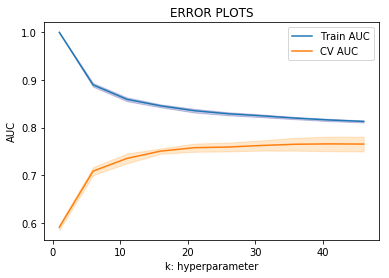

In [75]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc3= clf3.cv_results_['mean_train_score']
train_auc_std3= clf3.cv_results_['std_train_score']
cv_auc3 = clf3.cv_results_['mean_test_score'] 
cv_auc_std3= clf3.cv_results_['std_test_score']

plt.plot(k, train_auc3, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k,train_auc3 - train_auc_std3,train_auc3 + train_auc_std3,alpha=0.2,color='darkblue')

plt.plot(k, cv_auc3, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k,cv_auc3 - cv_auc_std3,cv_auc3 + cv_auc_std3,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [76]:
l=0
for i in k:
    print (i,train_auc3[l],cv_auc3[l],train_auc3[l]-cv_auc3[l] )
    l+=1

1 0.9997493734335839 0.5909054458609928 0.40884392757259114
6 0.8895429984131514 0.7086400796607918 0.18090291875235964
11 0.8592558452679775 0.7352804418976391 0.12397540337033841
16 0.8455279428435593 0.7507023179850789 0.09482562485848034
21 0.8353533732765447 0.757805892774096 0.07754748050244864
26 0.828895979678769 0.7592079212833326 0.06968805839543646
31 0.8245716754466473 0.7624911675983675 0.06208050784827979
36 0.8197452250561655 0.7650627350463665 0.05468249000979908
41 0.8158499206654 0.7657809721666139 0.05006894849878607
46 0.812863747755673 0.7653731961285056 0.04749055162716742


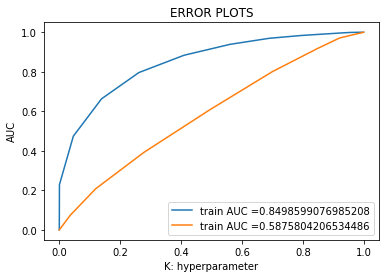

In [77]:
#training our model with the best optimal K, and find the AUC on test data and plot the ROC curve on both train and test. 
neigh3 = KNeighborsClassifier(n_neighbors=16, algorithm='kd_tree')
neigh3.fit(X_train_tfidfw2v_S, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr3, train_tpr3, thresholds3 = roc_curve(y_train, neigh3.predict_proba(X_train_tfidfw2v_S)[:,1])
test_fpr3, test_tpr3, thresholds3 = roc_curve(y_test, neigh3.predict_proba(X_test_tfidfw2v_S)[:,1])

plt.plot(train_fpr3, train_tpr3, label="train AUC ="+str(auc(train_fpr3, train_tpr3)))
plt.plot(test_fpr3, test_tpr3, label="train AUC ="+str(auc(test_fpr3, test_tpr3)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Train confusion matrix


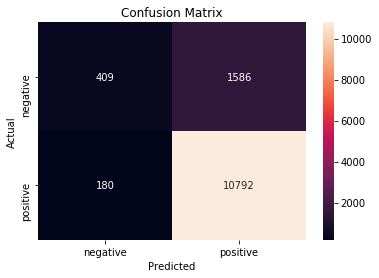

Test confusion matrix


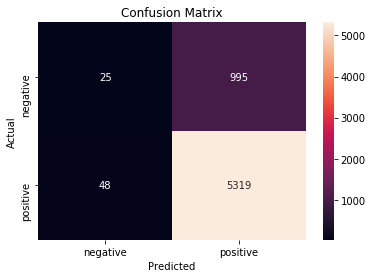

In [78]:
# Confusion Metric
print("Train confusion matrix")
matrix_train3= confusion_matrix(y_train, neigh3.predict(X_train_tfidfw2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train3 = pd.DataFrame(matrix_train3,columns,index)
sns.heatmap(df_matrix_train3, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test3= confusion_matrix(y_test, neigh3.predict(X_test_tfidfw2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test3 = pd.DataFrame(matrix_test3,columns,index)
sns.heatmap(df_matrix_test3, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Observation:
- Taking best k=16 as per the graph and the for loop result. Condisering the highest CV_SCORE and Train_score and the gap between them.
- The AUC of the train data and test data is > 0.5
- From the confusion matrix TPR is very high and TNR is very low. The model is bias towards +ve class.

In [86]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
x.add_row(["BOW", "Brute", 10, 0.504])
x.add_row(["TFIDF", "Brute", 11, 0.506])
x.add_row(["W2V", "Brute", 25, 0.798])
x.add_row(["TFIDFW2V", "Brute", 30, 0.772])
x.add_row(["BOW", "KD-Tree", 31, 0.685])
x.add_row(["TFIDF", "KD-Tree", 32, 0.566])
x.add_row(["W2V", "KD-Tree", 21, 0.660])
x.add_row(["W2V", "KD-Tree", 16, 0.587])
print ("Summarize the results: ")
print(x)

Summarize the results: 
+------------+---------+----------------+-------+
| Vectorizer |  Model  | Hyperparameter |  AUC  |
+------------+---------+----------------+-------+
|    BOW     |  Brute  |       10       | 0.504 |
|   TFIDF    |  Brute  |       11       | 0.506 |
|    W2V     |  Brute  |       25       | 0.798 |
|  TFIDFW2V  |  Brute  |       30       | 0.772 |
|    BOW     | KD-Tree |       31       | 0.685 |
|   TFIDF    | KD-Tree |       32       | 0.566 |
|    W2V     | KD-Tree |       21       |  0.66 |
|    W2V     | KD-Tree |       16       | 0.587 |
+------------+---------+----------------+-------+


# [6] Conclusions

- Highest accuracy of 0.798 found using vectorizer W2V from model KNN-BRUTE.
- All the model always perform good on training data than the test data.
- From the observation we noted all the models are bias towards a single class.
- Therefore we can't consider KNN as our ideal model to classify Amazon food review dataset.

#### Reference:
- www.appliedaicourse.com
- https://stackoverflow.com
- http://zetcode.com/python
